Testing DemEnt
==

Here's a notebook for playing with the `DemEnt` class for inverting the SFS

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from dement import DemEnt
import numpy as np
from scipy.optimize import minimize, check_grad
from scipy.special import erf
from scipy.special import expit
from matplotlib import pyplot as plt

In [10]:
print(DemEnt.__doc__)
print(DemEnt.__init__.__doc__)


    A class that implements the model of Rosen et al., but adds a Poisson
    random field for generating the SFS from ξ
    

        n: number of sampled haplotypes
        t: The time axis. The last epoch in t extends to infinity in Rosen, but
           we truncate if infinite=False
        y: vector of eta pieces
        r: mutation rate is per genome per generation (controls SFS noise)
        infinite: extend to infinity with constant size (otherwise truncate)
        


A few parameters that will be shared among models
--

In [14]:
t = np.linspace(0, 3e2, 300)
n = 200
r = 10

Inverting a few simple demographies
--
### True demographies to simulate with
$y$ values denote piecewise constant population size in each discrete time interval

#### exponential growth

In [6]:
y_growth = 1000 * np.exp(-t[1:]/20) + 100

#### sigmoid crash at 50 generations ago

In [7]:
y_crash = 1000 * (- .9 * expit(-.1 * (t[1:] - 50)) + 1)

### (Meta-)optimization parameters
[comment]: <> (Apparently table alignment with colons doesn't render in Jupyter)
| parameter  | type   | description  |
| :--------  | :----  | :----------  |
| `iterates` | `int` | Number of meta-optimization iterates using divergence from prior. The prior is updated after each meta-iterate.
| `lambda_prior` | `float` | Penalty parameter $\lambda_{\eta_0}$ on divergence from prior (will be reduced after each meta-iterate) |
| `lambda_diff` | `float` | Derivative penalty parameter $\lambda_{\eta'}$ |
| `weight_ramp` | `bool` | Ramp derivative penalty weight as time approaches the coalescent horizon |

### Compute the inversion and plot for each demography simulation
#### Eponential growth

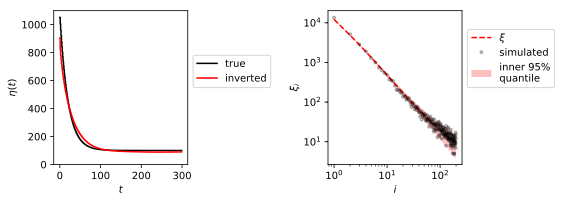

In [13]:
dement_growth = DemEnt(n, t, y_growth, r=r, infinite=True)
dement_growth.invert(iterates=1, lambda_prior=0, lambda_diff=1e-3, weight_ramp=True)

#### Sigmoidal crash

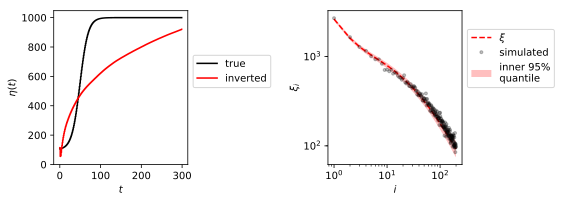

In [16]:
dement_crash = DemEnt(n, t, y_crash, r=r, infinite=True)
dement_crash.invert(iterates=1, lambda_prior=0, lambda_diff=1e-3, weight_ramp=True)